In [1]:
import sys
sys.path.append("../../")

from astronn.datasets import deltascuti, bedding, corot ,starmodels
from astronn.preprocess import predeltascuti, prebedding
from astronn import models

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import math
import pandas as pd
import shap
from scipy.signal import find_peaks, peak_widths
import pickle

import matplotlib.pyplot as plt

Using TensorFlow backend.


### Load data to fine tunning

In [2]:
df_ds = deltascuti()
deltascuti = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)
bedding_stars = bedding()
df_bedding = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

### Read trainned model

In [3]:
# Load model
#sepconv_mod = tf.keras.models.load_model("/home/roberto/Projects/sepconvnn_tmp_dos_200/")
sepconv_mod = tf.keras.models.load_model("/tmp/sepconvnn_tmp_dos_300/")
sepconv_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 351, 10)           1010      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 302, 10)           5010      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 151, 10)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 151, 10)           40        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 142, 10)           1010      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 133, 10)           1010      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 66, 10)            0

In [4]:
# Freeze base model
sepconv_mod.trainable = False

# Check trainable parameters on layers
for layer in sepconv_mod.layers:
    print("%s is trainable=%s" % (layer.name, layer.trainable))

conv1d is trainable=False
conv1d_1 is trainable=False
max_pooling1d is trainable=False
batch_normalization is trainable=False
conv1d_2 is trainable=False
conv1d_3 is trainable=False
max_pooling1d_1 is trainable=False
batch_normalization_1 is trainable=False
batch_normalization_2 is trainable=False
flatten is trainable=False
dense is trainable=False


### Fine tunning

In [5]:
#x = sepconv_mod.output
#x = layers.Dense(100, activation='sigmoid')(x)
#x = layers.Dropout(0.2)(x)

inputs = keras.Input(shape=(400, 2))
x = sepconv_mod(inputs, training=False)
outputs = layers.Dense(100, activation="softmax")(x)
x = keras.layers.Dropout(0.5)(x)
model = keras.Model(inputs, outputs)
model.compile()

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 2)]          0         
_________________________________________________________________
sequential (Sequential)      (None, 100)               74260     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
Total params: 84,360
Trainable params: 10,100
Non-trainable params: 74,260
_________________________________________________________________


#### Prepare data. Data augmentation

In [7]:
"""
preprocessor = predeltascuti()
for i in range(50):
        preprocessor.preprocess_files(
                input_folder="../../astronn/data/deltascuti/raw/*",
                output_folder="/tmp/ds_preprocessed/",
        )
preprocessor = prebedding(
        conf_file="../../astronn/data/bedding/parameters.csv", 
        cols=["tess", "dnu"])
for i in range(50):
        preprocessor.preprocess_files(
                input_folder="../../astronn/data/bedding/raw/*",
                output_folder="/tmp/bedding_preprocessed/",
        )
"""

'\npreprocessor = predeltascuti()\nfor i in range(50):\n        preprocessor.preprocess_files(\n                input_folder="../../astronn/data/deltascuti/raw/*",\n                output_folder="/tmp/ds_preprocessed/",\n        )\npreprocessor = prebedding(\n        conf_file="../../astronn/data/bedding/parameters.csv", \n        cols=["tess", "dnu"])\nfor i in range(50):\n        preprocessor.preprocess_files(\n                input_folder="../../astronn/data/bedding/raw/*",\n                output_folder="/tmp/bedding_preprocessed/",\n        )\n'

In [8]:
deltascuti_augmented = df_ds.load("/tmp/ds_preprocessed/*", batch_size=1)
bedding_augmented = df_ds.load("/tmp/bedding_preprocessed/*", batch_size=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [9]:
stars = [star for star in deltascuti.take(11)]
stars_augmented = [star for star in deltascuti_augmented.take(300)]
bedding = [star for star in df_bedding.take(57)]
bedding_augmented = [star for star in bedding_augmented.take(300)]


tf.Tensor([b'CID100866999'], shape=(1,), dtype=string)


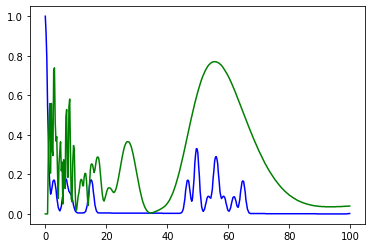

In [10]:
id = 23
print(stars_augmented[id][0])
plt.plot( np.arange(0, 100, 0.25), stars_augmented[id][1][0, :, 0], label="dft", color="blue")
plt.plot( np.arange(0, 100, 0.25), stars_augmented[id][1][0, :, 1], label="ac", color="green")
plt.show()

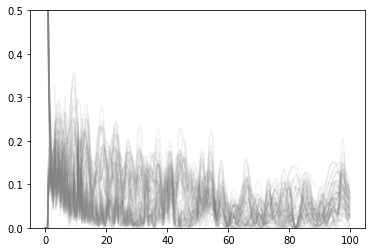

In [11]:
for s in stars_augmented:
    if s[0].numpy()==b'HD15082':
        plt.plot( np.arange(0, 100, 0.25), s[1][0, :, 0], label="dft", color="grey", alpha=0.1)
        plt.plot( np.arange(0, 100, 0.25), s[1][0, :, 1], label="ac", color="grey", alpha=0.1)
        plt.ylim(0, 0.5)

tf.Tensor([b'tess2018319095959-s0005-0000000031475829-0125-s_lc_det'], shape=(1,), dtype=string)


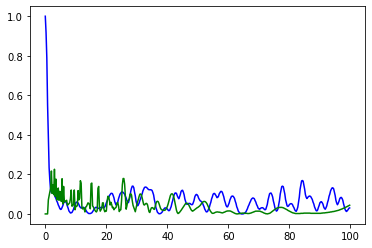

In [12]:
id = 36
print(bedding_augmented[id][0])
plt.plot( np.arange(0, 100, 0.25), bedding_augmented[id][1][0, :, 0], label="dft", color="blue")
plt.plot( np.arange(0, 100, 0.25), bedding_augmented[id][1][0, :, 1], label="ac", color="green")
plt.show()

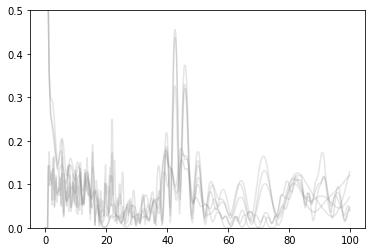

In [13]:
for s in bedding_augmented:
    if s[0].numpy()==b'tess2018319095959-s0005-0000000024344701-0125-s_lc_det':
        plt.plot( np.arange(0, 100, 0.25), s[1][0, :, 0], label="dft", color="grey", alpha=0.2)
        plt.plot( np.arange(0, 100, 0.25), s[1][0, :, 1], label="ac", color="grey", alpha=0.2)
        plt.ylim(0, 0.5)

In [14]:
import itertools
mixed_augmented = list(itertools.chain.from_iterable(zip(stars_augmented, bedding_augmented)))

In [15]:
import random

loss_fn = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

count = 0
for l in range(100):
    # Iterate over the batches of a dataset
    for star in stars_augmented:
        # Open a GradientTape.
        with tf.GradientTape() as tape:
            # Forward pass.
            predictions = model(star[1])
            # Compute the loss value for this batch.
            loss_value = loss_fn(tf.reshape(star[2], (1, 100)), predictions)
            if count % 50 == 0:
                print(loss_value)
                print(count)
        # Get gradients of loss wrt the *trainable* weights.
        gradients = tape.gradient(loss_value, model.trainable_weights)
        # Update the weights of the model.
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        count += 1

tf.Tensor(4.5806584, shape=(), dtype=float32)
0
tf.Tensor(4.5731683, shape=(), dtype=float32)
50
tf.Tensor(4.641404, shape=(), dtype=float32)
100
tf.Tensor(4.66263, shape=(), dtype=float32)
150
tf.Tensor(4.6425133, shape=(), dtype=float32)
200
tf.Tensor(4.656932, shape=(), dtype=float32)
250
tf.Tensor(4.530528, shape=(), dtype=float32)
300
tf.Tensor(4.524059, shape=(), dtype=float32)
350
tf.Tensor(4.596632, shape=(), dtype=float32)
400
tf.Tensor(4.6120973, shape=(), dtype=float32)
450
tf.Tensor(4.5976963, shape=(), dtype=float32)
500
tf.Tensor(4.6103063, shape=(), dtype=float32)
550
tf.Tensor(4.481166, shape=(), dtype=float32)
600
tf.Tensor(4.4747486, shape=(), dtype=float32)
650
tf.Tensor(4.5521426, shape=(), dtype=float32)
700
tf.Tensor(4.561482, shape=(), dtype=float32)
750
tf.Tensor(4.552946, shape=(), dtype=float32)
800
tf.Tensor(4.564047, shape=(), dtype=float32)
850
tf.Tensor(4.431968, shape=(), dtype=float32)
900
tf.Tensor(4.4256053, shape=(), dtype=float32)
950
tf.Tensor(4.507

tf.Tensor(3.3554776, shape=(), dtype=float32)
8150
tf.Tensor(3.566315, shape=(), dtype=float32)
8200
tf.Tensor(3.4073386, shape=(), dtype=float32)
8250
tf.Tensor(3.5509186, shape=(), dtype=float32)
8300
tf.Tensor(3.5298846, shape=(), dtype=float32)
8350
tf.Tensor(3.3209662, shape=(), dtype=float32)
8400
tf.Tensor(3.316159, shape=(), dtype=float32)
8450
tf.Tensor(3.532632, shape=(), dtype=float32)
8500
tf.Tensor(3.3663664, shape=(), dtype=float32)
8550
tf.Tensor(3.5163398, shape=(), dtype=float32)
8600
tf.Tensor(3.4941428, shape=(), dtype=float32)
8650
tf.Tensor(3.282043, shape=(), dtype=float32)
8700
tf.Tensor(3.277307, shape=(), dtype=float32)
8750
tf.Tensor(3.4994392, shape=(), dtype=float32)
8800
tf.Tensor(3.3258328, shape=(), dtype=float32)
8850
tf.Tensor(3.4822328, shape=(), dtype=float32)
8900
tf.Tensor(3.4588916, shape=(), dtype=float32)
8950
tf.Tensor(3.2435894, shape=(), dtype=float32)
9000
tf.Tensor(3.2389252, shape=(), dtype=float32)
9050
tf.Tensor(3.4667397, shape=(), dtype

tf.Tensor(2.766253, shape=(), dtype=float32)
16150
tf.Tensor(2.4647374, shape=(), dtype=float32)
16200
tf.Tensor(2.4617677, shape=(), dtype=float32)
16250
tf.Tensor(2.8315876, shape=(), dtype=float32)
16300
tf.Tensor(2.457129, shape=(), dtype=float32)
16350
tf.Tensor(2.7862253, shape=(), dtype=float32)
16400
tf.Tensor(2.743716, shape=(), dtype=float32)
16450
tf.Tensor(2.43815, shape=(), dtype=float32)
16500
tf.Tensor(2.435244, shape=(), dtype=float32)
16550
tf.Tensor(2.8111296, shape=(), dtype=float32)
16600
tf.Tensor(2.4279892, shape=(), dtype=float32)
16650
tf.Tensor(2.7644565, shape=(), dtype=float32)
16700
tf.Tensor(2.7216556, shape=(), dtype=float32)
16750
tf.Tensor(2.4120023, shape=(), dtype=float32)
16800
tf.Tensor(2.4091592, shape=(), dtype=float32)
16850
tf.Tensor(2.7911124, shape=(), dtype=float32)
16900
tf.Tensor(2.3992507, shape=(), dtype=float32)
16950
tf.Tensor(2.7431176, shape=(), dtype=float32)
17000
tf.Tensor(2.7000656, shape=(), dtype=float32)
17050
tf.Tensor(2.386289

tf.Tensor(2.4250982, shape=(), dtype=float32)
24100
tf.Tensor(1.8166332, shape=(), dtype=float32)
24150
tf.Tensor(2.3425233, shape=(), dtype=float32)
24200
tf.Tensor(2.3053737, shape=(), dtype=float32)
24250
tf.Tensor(1.8842505, shape=(), dtype=float32)
24300
tf.Tensor(1.8826439, shape=(), dtype=float32)
24350
tf.Tensor(2.4138346, shape=(), dtype=float32)
24400
tf.Tensor(1.7962594, shape=(), dtype=float32)
24450
tf.Tensor(2.3297236, shape=(), dtype=float32)
24500
tf.Tensor(2.2932801, shape=(), dtype=float32)
24550
tf.Tensor(1.8674599, shape=(), dtype=float32)
24600
tf.Tensor(1.8658895, shape=(), dtype=float32)
24650
tf.Tensor(2.4028292, shape=(), dtype=float32)
24700
tf.Tensor(1.7761539, shape=(), dtype=float32)
24750
tf.Tensor(2.3171759, shape=(), dtype=float32)
24800
tf.Tensor(2.281471, shape=(), dtype=float32)
24850
tf.Tensor(1.8509467, shape=(), dtype=float32)
24900
tf.Tensor(1.8494118, shape=(), dtype=float32)
24950
tf.Tensor(2.3920755, shape=(), dtype=float32)
25000
tf.Tensor(1.7

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
['KIC8262223']


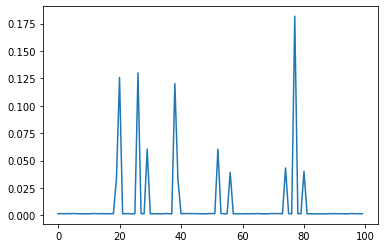

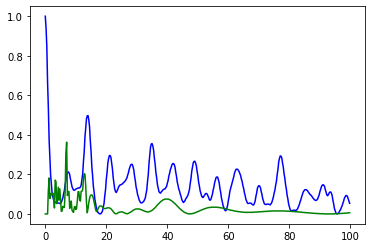

['KIC8262223', 'kic10661783']


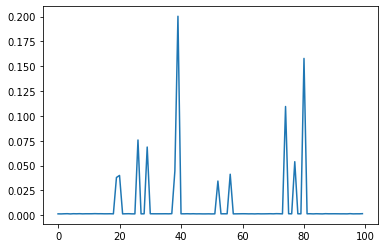

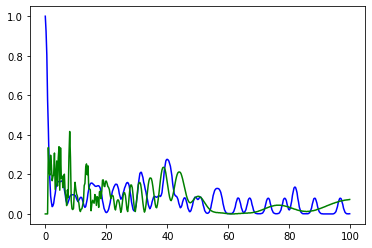

['KIC8262223', 'kic10661783', 'HD15082']


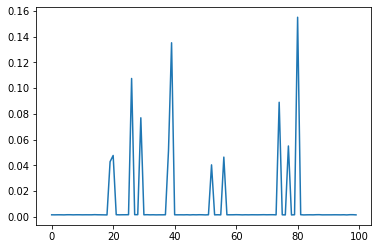

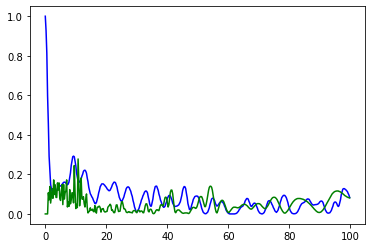

['KIC8262223', 'kic10661783', 'HD15082', 'KIC10080943']


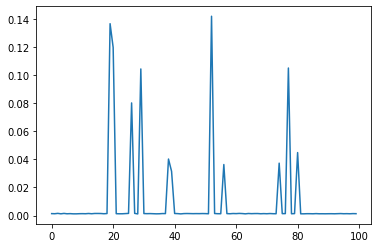

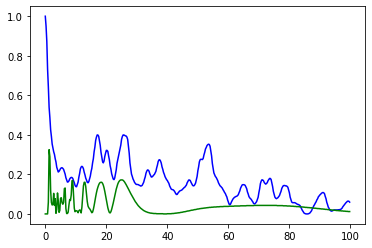

['KIC8262223', 'kic10661783', 'HD15082', 'KIC10080943', 'KIC9851944']


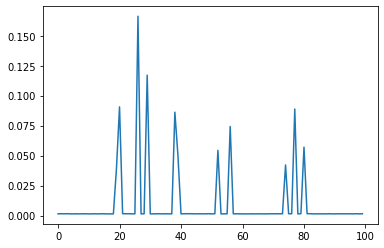

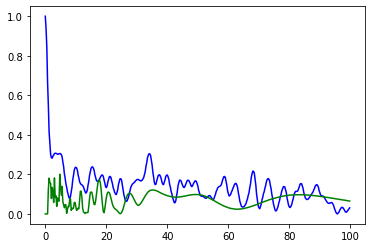

['KIC8262223', 'kic10661783', 'HD15082', 'KIC10080943', 'KIC9851944', 'kic4544587']


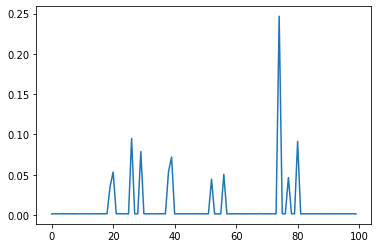

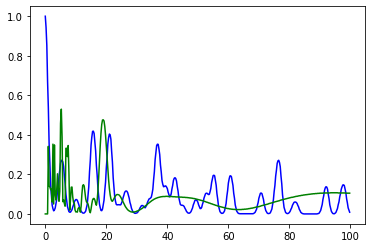

['KIC8262223', 'kic10661783', 'HD15082', 'KIC10080943', 'KIC9851944', 'kic4544587', 'HD159561']


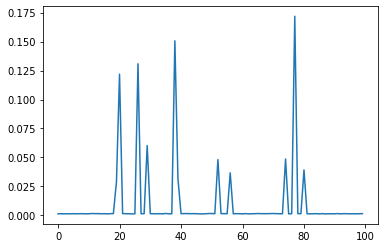

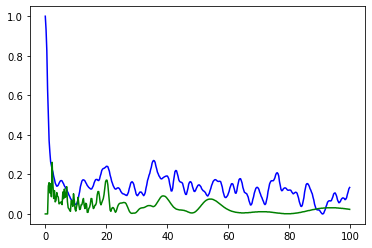

['KIC8262223', 'kic10661783', 'HD15082', 'KIC10080943', 'KIC9851944', 'kic4544587', 'HD159561', 'KIC3858884']


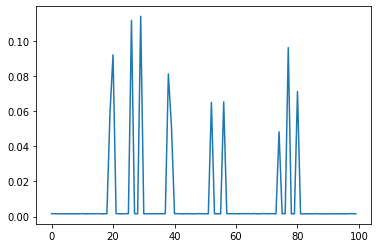

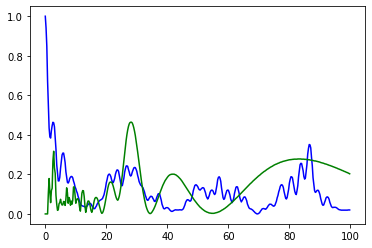

['KIC8262223', 'kic10661783', 'HD15082', 'KIC10080943', 'KIC9851944', 'kic4544587', 'HD159561', 'KIC3858884', 'CID105906206']


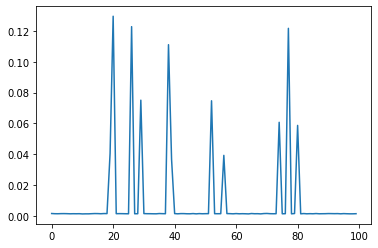

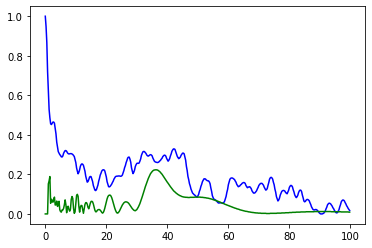

['KIC8262223', 'kic10661783', 'HD15082', 'KIC10080943', 'KIC9851944', 'kic4544587', 'HD159561', 'KIC3858884', 'CID105906206', 'HD172189']


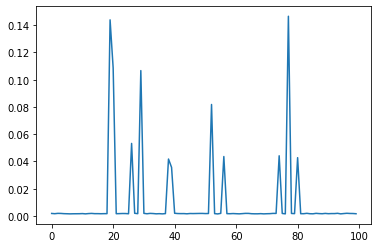

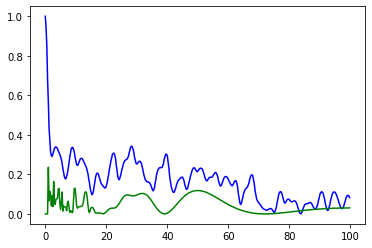

['KIC8262223', 'kic10661783', 'HD15082', 'KIC10080943', 'KIC9851944', 'kic4544587', 'HD159561', 'KIC3858884', 'CID105906206', 'HD172189', 'CID100866999']


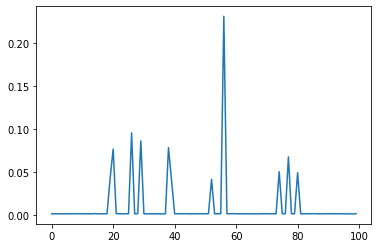

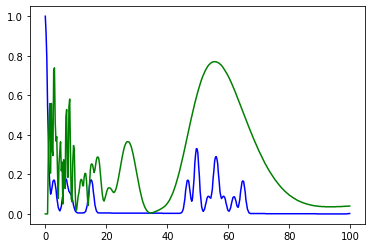

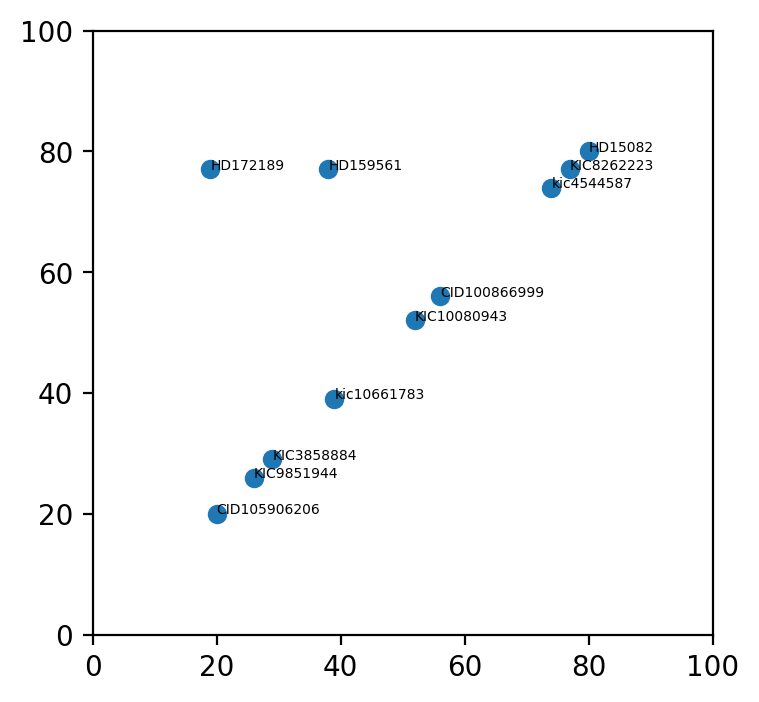

[ 0  0  0  0  0  0 39  0  0 58  0]
8.818181818181818
444.09090909090907
[77, 39, 80, 52, 26, 74, 77, 29, 20, 77, 56]
[77, 39, 80, 52, 26, 74, 38, 29, 20, 19, 56]
['KIC8262223', 'kic10661783', 'HD15082', 'KIC10080943', 'KIC9851944', 'kic4544587', 'HD159561', 'KIC3858884', 'CID105906206', 'HD172189', 'CID100866999']


In [16]:
def get_peak_width(position, peaks, peaks_width, peaks_sorted_by_prob):
    """
    """
    peak_id = np.where(probs == peaks_sorted_by_prob[position])[0][0]
    return (peak_id, peaks_width[0][np.where(peaks == peak_id)[0][0]])

x= []
y = []
l = []
for star in stars:
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    l.append(star[0].numpy()[0].decode("utf-8"))
    probs = model.predict(star[1])[0]
    print(l)
    plt.plot(probs)
    plt.show()

    plt.plot( np.arange(0, 100, 0.25), star[1][0, :, 0], label="dft", color="blue")
    #plt.plot(x, star[1][0, :, 1], label="hod", color="orange", alpha=0.5)
    plt.plot( np.arange(0, 100, 0.25), star[1][0, :, 1], label="ac", color="green")
    plt.show()
    peaks, _ = find_peaks(probs, height=0, distance=5)
    peaks_width = peak_widths(probs, peaks)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
    best_peak, best_peak_width = get_peak_width(0, peaks, peaks_width, peaks_sorted_by_prob)
    x.append(best_peak)
    y.append(target)

plt.subplots(1, figsize=(4, 4), dpi=200)
plt.scatter(y, x, label=l)
for i, txt in enumerate(l):
    plt.annotate(txt, (y[i], x[i]), size=5)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()    

print(np.asarray(x)-np.asarray(y))
print(np.mean(np.asarray(x)-np.asarray(y)))
print(np.mean(np.power(np.asarray(x)-np.asarray(y), 2)))
print(x)
print(y)
print(l)


-23.57309941520468
1184.0954804707242
[38, 26, 74, 38, 20, 74, 26, 26, 26, 77, 38, 77, 26, 26, 56, 26, 26, 26, 56, 56, 38, 77, 74, 74, 26, 56, 26, 74, 74, 74, 26, 38, 26, 74, 74, 74, 74, 39, 77, 20, 74, 56, 77, 80, 26, 39, 38, 74, 38, 26, 26, 77, 26, 74, 74, 39, 26]
[81.01851851851852, 81.01851851851852, 69.44444444444444, 69.44444444444444, 81.01851851851852, 81.01851851851852, 81.01851851851852, 57.87037037037037, 57.87037037037037, 69.44444444444444, 69.44444444444444, 69.44444444444444, 69.44444444444444, 69.44444444444444, 69.44444444444444, 81.01851851851852, 81.01851851851852, 81.01851851851852, 81.01851851851852, 69.44444444444444, 69.44444444444444, 69.44444444444444, 69.44444444444444, 81.01851851851852, 81.01851851851852, 69.44444444444444, 81.01851851851852, 81.01851851851852, 81.01851851851852, 69.44444444444444, 81.01851851851852, 69.44444444444444, 81.01851851851852, 69.44444444444444, 69.44444444444444, 69.44444444444444, 69.44444444444444, 81.01851851851852, 57.8703703

(0.0, 100.0)

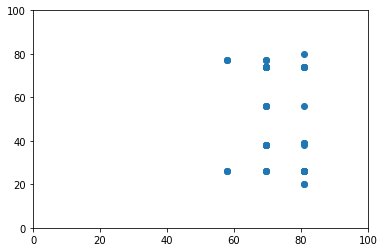

In [17]:

x= []
y = []
l = []
for star in bedding:
    target = np.where(star[2].numpy().flat == 1)[0].flat[0] / 0.0864
    l.append(star[0].numpy()[0].decode("utf-8"))
    probs = model.predict(star[1])[0]
    peaks, _ = find_peaks(probs, height=0, distance=5)
    peaks_width = peak_widths(probs, peaks)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
    best_peak, best_peak_width = get_peak_width(0, peaks, peaks_width, peaks_sorted_by_prob)
    x.append(best_peak)
    y.append(target)

plt.scatter(y, x, label=l)
#print(np.asarray(x)-np.asarray(y))
print(np.mean(np.asarray(x)-np.asarray(y)))
print(np.mean(np.power(np.asarray(x)-np.asarray(y), 2)))
print(x)
print(y)
print(l)
plt.xlim(0, 100)
plt.ylim(0, 100)

In [18]:
np.mean(np.power(np.asarray(x)-np.asarray(y),2))

1184.0954804707242